In [1]:
from diffusers import StableDiffusionControlNetPipeline
from matplotlib import pyplot as plt
%matplotlib inline
import torch
import PIL.Image


def test(pipeline):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    pipeline = pipeline.to(device)

    texts = [
        'red circle with blue background',
        'cyan circle with brown floral background',
    ]

    images = [
        PIL.Image.open('images/conditioning_image_1.png').convert('RGB'),
        PIL.Image.open('images/conditioning_image_2.png').convert('RGB'),
    ]

    plt.figure(figsize=(10, 5))
    for i in range(2):
        image = pipeline(texts[i], images[i], num_inference_steps=20).images[0]

        plt.subplot(1, 2, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

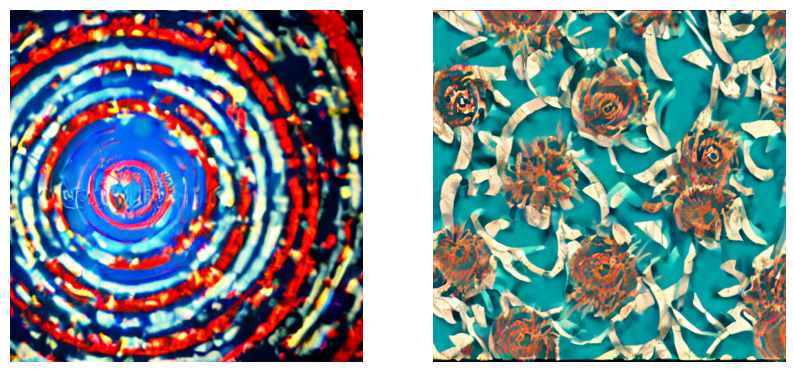

In [2]:
from diffusers import UNet2DConditionModel, ControlNetModel
from transformers import PretrainedConfig

%run controlnet_model.ipynb


#包装类
class MyControlNetModel(ControlNetModel):

    def __init__(self):
        super().__init__(cross_attention_dim=768)
        controlnet = ControlNet(PretrainedConfig())
        load_params(controlnet, unet)

        self.controlnet = controlnet

    def forward(self,
                sample,
                timestep,
                encoder_hidden_states,
                controlnet_cond,
                conditioning_scale=1.0,
                class_labels=None,
                timestep_cond=None,
                attention_mask=None,
                cross_attention_kwargs=None,
                return_dict=True):

        timestep = timestep.reshape(1)
        return self.controlnet(out_vae_noise=sample,
                               noise_step=timestep,
                               out_encoder=encoder_hidden_states,
                               condition=controlnet_cond)


#测试未训练的模型
unet = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5',
                                            subfolder='unet')

controlnet = MyControlNetModel()

pipeline = StableDiffusionControlNetPipeline.from_pretrained(
    'runwayml/stable-diffusion-v1-5',
    unet=unet,
    controlnet=controlnet,
    safety_checker=None)

test(pipeline)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

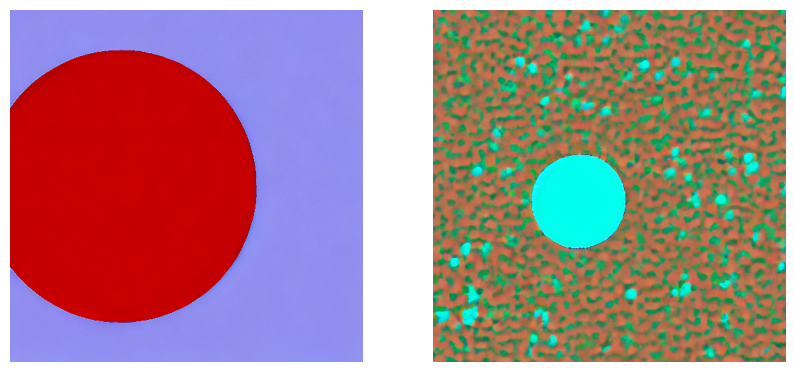

In [5]:
pipeline.controlnet.controlnet = torch.load('./save/controlnet.model')

test(pipeline)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

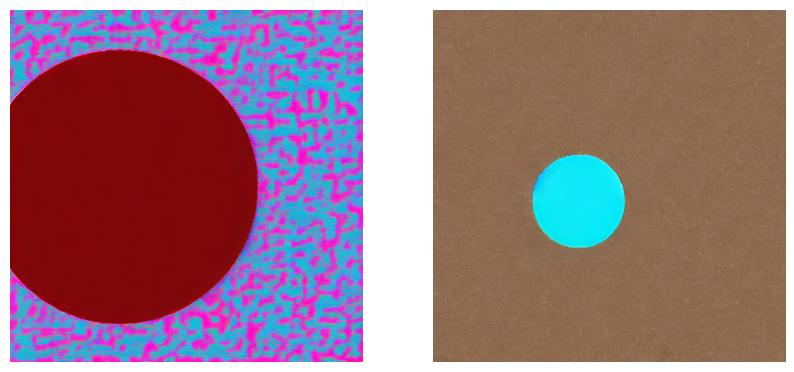

In [7]:
pipeline.controlnet.controlnet = ControlNet.from_pretrained(
    'lansinuote/diffusion.7.control_net')

test(pipeline)